# Телеком. Предсказание оттока клиентов.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель:** предсказать вероятность ухода клиента


**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

**Также доступны такие услуги:**

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Описание полей данных:**

- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` –  безналичный расчет,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка




**План работы**

1. **Загрузка данных:** Загрузить данные и провести первоначальное знакомство с данными. Выделить целевой признак.
2. **Предобработка и исследовательский анализ данных:** Провести предобработку и исследовательский анализ данных.  При необходимости преобразовать и/или добавить новые признаки.
3. **Моделирование:** Подготовить данные для моделирования: разделить данные на тренировочную и тестовую выборки, провести необходимые преобразования. Построить модели и провести подбор гиперпараметров.
4. **Тестирование и выводы:** Провести тестировыние выбранной модели





In [1]:
#!pip install pandas_profiling
#!pip install scikit-learn==1.2.1
#!pip install imblearn

In [2]:
import glob

import pandas as pd
import numpy as np
import ydata_profiling 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE



from catboost import CatBoostClassifier, Pool

In [3]:
RAND = 130223 

plt.rcParams['figure.figsize'] = (20,5)
pd.set_option('mode.chained_assignment', None)

## Загрузка данных

In [4]:
files = glob.glob('/datasets/final_provider/*')
files

['/datasets/final_provider/internet.csv',
 '/datasets/final_provider/phone.csv',
 '/datasets/final_provider/personal.csv',
 '/datasets/final_provider/contract.csv']

Проверим, какие есть данные в файлах:

In [5]:
for itm in files:
    print(f'File {itm}')
    temp_df = pd.read_csv(itm)
    display(temp_df.head(3))
    print(temp_df.shape)
    print(f'ID duple {any(temp_df["customerID"].duplicated())}\n_______________________')
del temp_df

File /datasets/final_provider/internet.csv


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


(5517, 8)
ID duple False
_______________________
File /datasets/final_provider/phone.csv


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


(6361, 2)
ID duple False
_______________________
File /datasets/final_provider/personal.csv


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


(7043, 5)
ID duple False
_______________________
File /datasets/final_provider/contract.csv


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


(7043, 8)
ID duple False
_______________________


Во всех файлах есть уникальный customerID, по которому можно их соединить.

In [6]:
df_telecom = pd.read_csv(files[0], index_col='customerID')

In [7]:
for itm in files[1:]:
    df_telecom = pd.concat([df_telecom, pd.read_csv(itm, index_col='customerID')], axis=1)
df_telecom.head(3)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [8]:
df_telecom.columns = df_telecom.columns.str.replace(r'(.)([A-Z].)', r'\1_\2', regex=True).str.lower()

In [9]:
# ID duple
any(df_telecom.index.duplicated())

False

In [10]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 2569-WGERO
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   internet_service   5517 non-null   object 
 1   online_security    5517 non-null   object 
 2   online_backup      5517 non-null   object 
 3   device_protection  5517 non-null   object 
 4   tech_support       5517 non-null   object 
 5   streaming_tv       5517 non-null   object 
 6   streaming_movies   5517 non-null   object 
 7   multiple_lines     6361 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  begin_date         7043 non-null   object 
 13  end_date           7043 non-null   object 
 14  type               7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method

In [11]:
df_telecom['target'] = (df_telecom['end_date'] != 'No').astype(int)

**Вывод:** данные загружены, соединены в один датафрейм. Создан целевой признак. <br>
Данные содержат 7043 строки и 19 признаков(не считая целевой), имеются пропуски. 5517 пользователей интернета, 6361 телефонии. <br> Все ID пользователей уникальны.<br>
Данные готовы к предобработке и исследовательскому анализу

## Предобработка и исследовательский анализ данных

In [12]:
df_telecom.describe(include='all')

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
count,5517,5517,5517,5517,5517,5517,5517,6361,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043.000000
unique,2,2,2,2,2,2,2,2,2,NaN,2,2,77,5,3,2,4,NaN,6531,NaN
top,Fiber optic,No,No,No,No,No,No,No,Male,NaN,No,No,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,NaN
freq,3096,3498,3088,3095,3473,2810,2785,3390,3555,NaN,3641,4933,366,5174,3875,4171,2365,NaN,11,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,0.265370
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,0.441561
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,1.000000


Выделяется `total_charges`, который describe определил, как категориальный, а должен быть числовым, проверим:

In [13]:
df_telecom[df_telecom['total_charges'].apply(pd.to_numeric, errors="coerce").isna()]

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,DSL,Yes,No,Yes,Yes,Yes,No,NaN,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
5709-LVOEQ,DSL,Yes,Yes,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1371-DWPAZ,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
4075-WKNIU,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,,0
2775-SEFEE,DSL,Yes,Yes,No,Yes,No,No,Yes,Male,0,No,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,,0
3115-CZMZD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,,0
4367-NUYAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,,0
7644-OMVMY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3213-VVOLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,,0


Таким образом определили, что в столбце `total_charges` есть "не явные" пропущенные значения для пользователей, которые пришли в компанию только что. Этих данных мало и использовать подобные данные для обучения сомнительная идея, удалим их и приведем столбец `total_charges` к типу float

In [14]:
df_telecom = df_telecom[df_telecom['total_charges'] != ' ']
df_telecom['total_charges'] = df_telecom['total_charges'].astype('float')

In [2]:
#ydata_profiling.ProfileReport(df_telecom,  
#                              title="Телеком",            
#                              correlations={"auto": {"calculate": False},
#                                            "cramers": {"calculate": True},
#                                            "phi_k": {"calculate": True},})

Перед предварительными выводами по данным рассмотрим некоторые интересные моменты из отчета отдельно:

In [16]:
df_telecom[df_telecom['internet_service'].isna()]['target'].value_counts(normalize=True)

0    0.925658
1    0.074342
Name: target, dtype: float64

In [17]:
df_telecom[df_telecom['multiple_lines'].isna()]['target'].value_counts(normalize=True)

0    0.75
1    0.25
Name: target, dtype: float64

In [18]:
df_telecom.dropna()['target'].value_counts(normalize=True)

0    0.671772
1    0.328228
Name: target, dtype: float64

In [19]:
# временные
df_dates = df_telecom[df_telecom['total_charges'] != ' ']
df_dates['payed'] = df_dates['total_charges'].astype('float') / df_dates['monthly_charges']
df_dates.loc[df_dates['end_date'] == "No",'end_date'] = '2020-02-01'
df_dates['activ'] = (pd.to_datetime(df_dates['end_date']) - pd.to_datetime(df_dates['begin_date'])).dt.days // 30

In [20]:
# пользователи активностью менее 3 мес
df_dates[df_dates['activ'] < 3].shape

(851, 22)

In [21]:
# пользователи, активные менее 11 месяцев с оплатой год и 2
df_dates.query('activ < 11 and type != "Month-to-month"').shape

(131, 22)

In [22]:
df_dates[['payed','activ']].head()

,payed,activ
customerID,,
7590-VHVEG,1.000000,1
5575-GNVDE,33.178227,34
3668-QPYBK,2.008357,2
7795-CFOCW,43.516548,45
9237-HQITU,2.144979,2


In [23]:
(df_dates['payed'] - df_dates['activ']).sort_values()

customerID
8395-ETZKQ   -7.792308
4821-WQOYN   -7.017413
2525-GVKQU   -6.941748
2560-WBWXF   -6.935818
4277-BWBML   -6.691729
                ...   
6010-DDPPW    6.170974
8207-VVMYB    6.190385
5893-KCLGT    6.341772
1399-OUPJN    7.407595
8241-JUIQO    7.706941
Length: 7032, dtype: float64

In [24]:
((df_dates['payed'] - df_dates['activ']) > 0.9).mean()

0.13353242320819111

In [25]:
del df_dates

**Первый взгляд:**

1. Пропущенные значения у данных категории инета. В целом, вполне смело можно в internet_service ввести категорию типа "not use" и остальные стобики сделать No. Инет не подключен, услуг нет, логично - но данная штука может дать кривую оценку, т.к. сознательно нарушаем баланс у параметров - скорей всего, стоит и в услугах сделать отдельную категорию.


2. Для телефонных услуг почти аналогично, но там будет 3 категории стиля "не подключено, одна, несколько".


3. Но так же интересно попробовать идею "разбить" на два разных датасета и 2 модели. Отдельно делать предсказания для интернет-услуг и отдельно для телефона. Между собой таблички можно "связать" через булин "пользуется инетом/телефоном: да/нет". Компания должна быть заинтересована, чтоб клиент не отказывался от части услуг в том числе. Ну и у них немного разное соотношение по целевому, люди, которые не используют инет от услуг практически не отказываются, 7% (а тут, кстати, тоже можно будет проверить и оставить только людей с инетом, но это 21% потеря, многовато будет :))


4. Столбики даты. end_date идет для определения целевого, в признаки попасть не должен. begin_date может быть полезен, но его стоит попробовать перевести в признак типа "сколько месяцев клиент в компании" на текущий момент. 


5. total_charges - содержит псевдо-пропущенные значения для новых пользователей, их мало, можно удалить (плюс еще предсказывать на новых пользователях сомнительно так :)). Было проверено, что плата за месяц значение не постоянное и не получится достоверно определить, сколько человек имеют оплату "наперед". По дате было определено, что 131 человек в компании менее 11 месяцев, но оплата на год или 2, для создания нового признака это слишком мало. 
<br/>Но можно попробовать что-то намутить типа (total_charges / "сколько месяцев клиент в компании") - от родственного monthly_charges будет отличаться. И разница их может быть полезна :)


6. Неплохо может смотреться признак "количество подключенных услуг".


7. Остальное пока смотрится вполне нормально. Мусорных не наблюдается. В процессе может еще что накопается :)

Рассмотрим немного подробнее целевой признак:

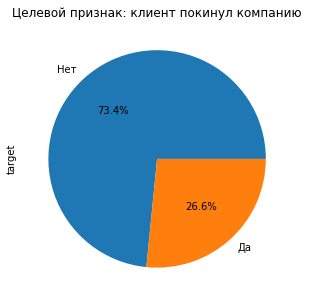

In [26]:
df_telecom['target'].value_counts().plot(kind='pie', 
                                         title='Целевой признак: клиент покинул компанию',
                                         autopct='%.1f%%',
                                         labels=['Нет', 'Да']);

Целевой признак распределен неравномерно: остается клиентов больше, чем уходит.

Построим графики целевого в зависимости от других признаков:

In [27]:
def plot_hists(data: pd.DataFrame,
               nrow: int, 
               ncol: int,    
               suptitle_: str,
               depend: str = 'target',
               figsize_: tuple = (20, 30)) -> None:
    
    fig = plt.figure(figsize=figsize_)
    fig.suptitle(suptitle_, fontsize=30)
    plt.subplots_adjust(top=0.95, hspace=0.4)
    
    for i, itm in enumerate(data.columns.drop(depend), 1):
        fig.add_subplot(nrow, ncol, i)
        sns.histplot(data[[itm, depend]].fillna('NAN Cat'), x=itm, hue=depend, 
                     alpha=0.4, stat='probability', palette='terrain_r')
        plt.xlabel('')
        plt.title(itm, fontsize=15)
        plt.legend(['Ушел', 'Остался'], loc='upper right')

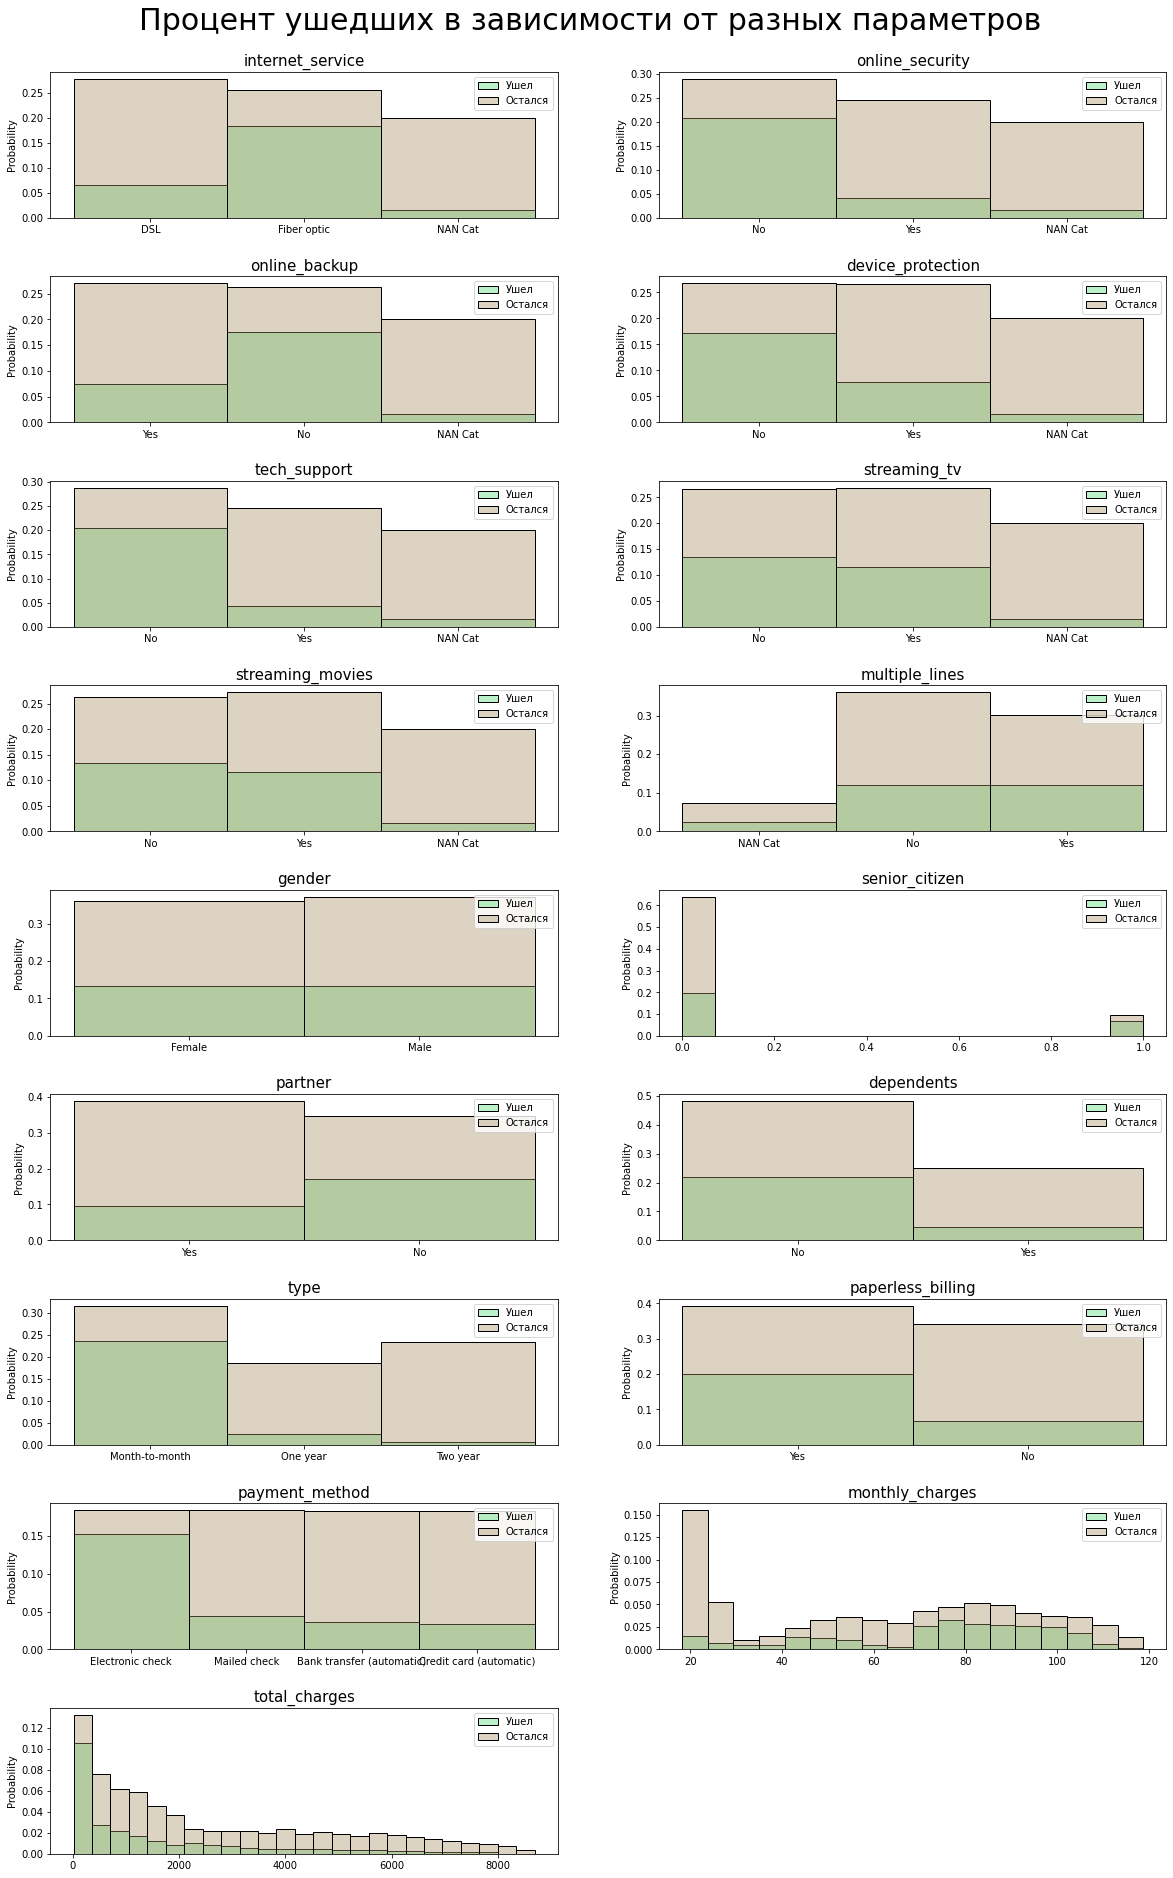

In [28]:
plot_hists(df_telecom.drop(['end_date', 'begin_date'], axis=1),
          nrow = 9,
          ncol = 2,
          suptitle_ = 'Процент ушедших в зависимости от разных параметров')

Можно обратить внимание, что для некоторых параметров (например, `gender`) %% ушедших в зависимости от категории не изменяется(что может означать, что признак не значим/мало значим), а для некоторых есть достаточно большие отличия (например, `type`) есть значимые отличия.

На данном этапе не будем удалять признаки и посмотрим их "в деле".

**Обработка признаков:** <br>


Пропущенные значения будем обрабатывать с учетом планов построить несколько вариантов моделей:
- заполнить пропуски в  дополнительных услугах значением **'No'(0)** и заполнить основные услуги **'Not Used'(-1)**
- заполнить все пропуски **'Not Used'(-1)**
- не заполнять пропущенные значения (для варианта разбиения на 2 модели)

Новые признаки:
- количество подключенных услуг
- сколько времени клиент в компании
- дополнительные - "дублирующие" признак `total_charges`, для теста - возможно, они покажут себя лучше при построении модели
    - средняя плата: total_charges / "сколько месяцев клиент в компании" 
    - разница средней платы и monthly_charges

Все необходимые преобразования типа OHE, OrderEnc будут сделаны в разделе моделирования, в зависимости от модели.

**Классы для обработки через Pipeline:**

In [29]:
class DummyTrans(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X=None):
        return self

In [30]:
#before yesno transform in Pipe
class DateDelta(DummyTrans):

    def __init__(self, last_date: str = ''):
        if last_date:
            self.last_date = pd.to_datetime(last_date).normalize()
        else:
            self.last_date = pd.to_datetime('today').normalize()

    def transform(self, X, y=None):
        X = X.copy()
        #create col if not exist
        if 'end_date' not in X:
            X['end_date'] = 'No'
        #replace 'No' and Nan
        X['end_date'] = X['end_date'].apply(pd.to_datetime, errors="coerce").fillna(self.last_date)
        X['date_delta'] = np.round((X['end_date'] - pd.to_datetime(X['begin_date'])).dt.days / 30) 
        X = X.drop(['end_date','begin_date'], axis=1)
        return X

In [31]:
class ChangeYesNo(DummyTrans):
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X.replace(r'^Yes$', 1, regex=True)
        X = X.replace(r'^No$', 0, regex=True)
        return X

In [32]:
class ServiceCount(DummyTrans):
    
    def __init__(self, service_columns):
        self.service_columns = service_columns

    def transform(self, X, y=None):
        X = X.copy()
        X['service_sum'] = X[self.service_columns].sum(axis=1).astype(int)
        
        X['use_web'] = (X['internet_service'].notna()).astype(int)
        return X

In [33]:
#after DateDelta in Pipe
class AvgCharges(DummyTrans):
    
    def transform(self, X, y=None):
        X = X.copy()
        self.avg = np.round(X['total_charges'] / X['date_delta'], 2).fillna(0)
        X['delta_charges'] = np.round(X['monthly_charges'] - self.avg, 2)
        return X

In [34]:
#not SimpleImputer :))
class CleverFill(DummyTrans):
    
    def __init__(self, fill_value, not_clever_cols: list = []):
        self.fill_value = fill_value
        self.not_clever_cols = not_clever_cols
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.not_clever_cols:
            X[self.not_clever_cols] = X[self.not_clever_cols].fillna(0)
        X = X.apply(lambda x: x.fillna(self.fill_value) if x.dtype.kind in 'biufc' else x.fillna('Not Use'))
        #  biufc : b bool, i int (signed), u unsigned int, f float, c complex
        return X

Классы подготовлены. Выделим колонки дополнительных услуг и напишем Pipeline. <br>
Подготовим вариант без заполнения пропусков, будут заполнены чуть позже.

In [35]:
service_columns = ['online_security', 'online_backup',
                   'device_protection', 'tech_support', 
                   'streaming_tv', 'streaming_movies']

In [36]:
prepresessor_pipe = make_pipeline(DateDelta('02-01-2020'),
                                  ChangeYesNo(),
                                  ServiceCount(service_columns), 
                                  AvgCharges()
                                 )

In [37]:
df_telecom_adv = prepresessor_pipe.fit_transform(df_telecom)
df_telecom_adv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 2569-WGERO
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   internet_service   5512 non-null   object 
 1   online_security    5512 non-null   float64
 2   online_backup      5512 non-null   float64
 3   device_protection  5512 non-null   float64
 4   tech_support       5512 non-null   float64
 5   streaming_tv       5512 non-null   float64
 6   streaming_movies   5512 non-null   float64
 7   multiple_lines     6352 non-null   float64
 8   gender             7032 non-null   object 
 9   senior_citizen     7032 non-null   int64  
 10  partner            7032 non-null   int64  
 11  dependents         7032 non-null   int64  
 12  type               7032 non-null   object 
 13  paperless_billing  7032 non-null   int64  
 14  payment_method     7032 non-null   object 
 15  monthly_charges    7032 non-null   float64
 16  total_charges 

In [38]:
df_telecom_adv.sample(3, random_state=RAND)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,...,type,paperless_billing,payment_method,monthly_charges,total_charges,target,date_delta,service_sum,use_web,delta_charges
customerID,,,,,,,,,,,,,,,,,,,,,
2495-TTHBQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Female,0,...,One year,1,Mailed check,20.4,84.75,0,4.0,0,0,-0.79
5288-AHOUP,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Male,1,...,Month-to-month,1,Electronic check,78.5,874.20,0,11.0,1,1,-0.97
6496-JDSSB,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Female,0,...,Month-to-month,1,Bank transfer (automatic),80.0,624.60,0,8.0,1,1,1.92


Все хорошо, новые признаки добавлены.

Построим графики для добавленных признаков:


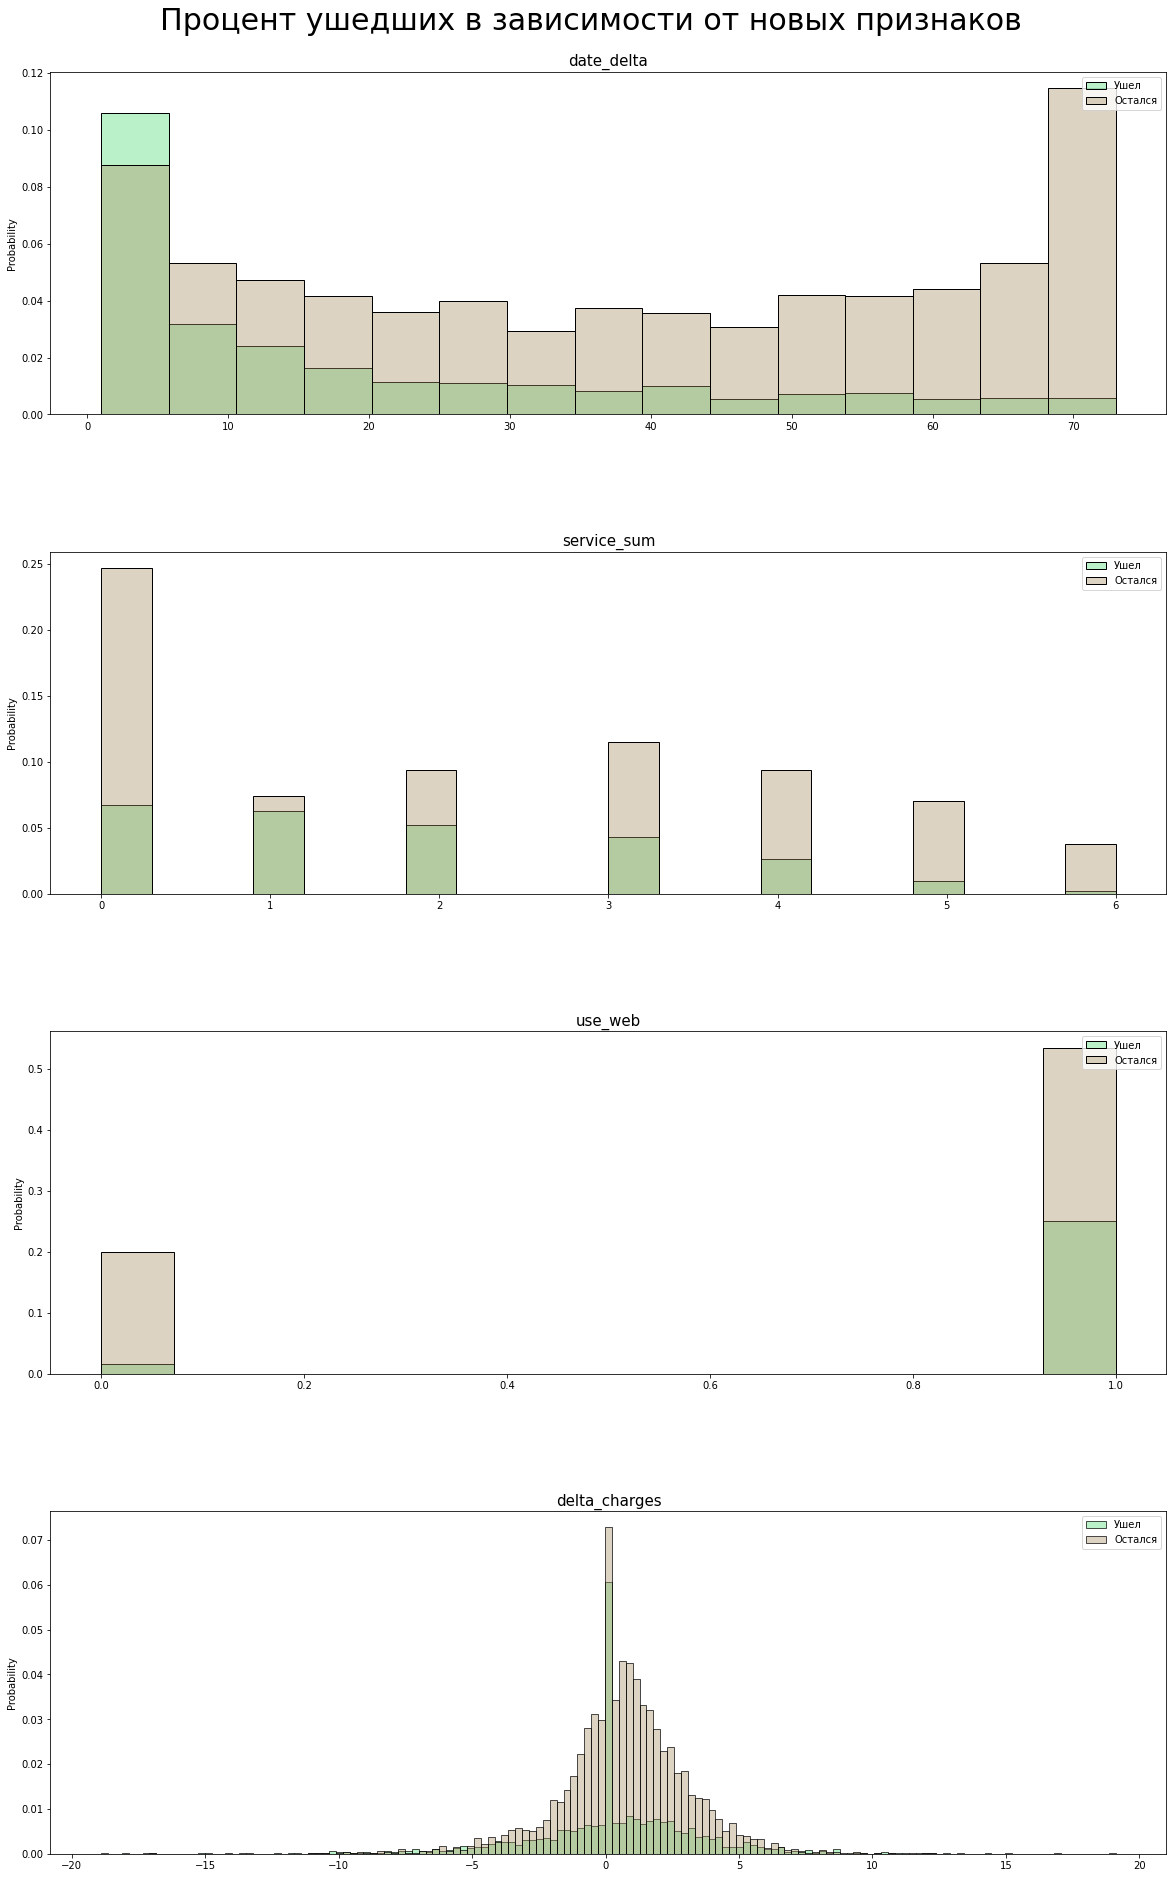

In [39]:
plot_hists(df_telecom_adv[['date_delta', 'service_sum', 'use_web', 
                           'delta_charges','target']],
           nrow = 4,
           ncol = 1,
           suptitle_ = 'Процент ушедших в зависимости от новых признаков')

Новые признаки выглядят достаточно интересно и могут быть полезны при моделировании.

**Вывод:**  

- изучены данные, обнаружен дисбаланс в целевом признаке
- удалены строки с аномальными значениями
- удалены признаки даты
- заменены пропущенные значения
- построены новые признаки


____________________________

## Моделирование


______________________
***Используемые функции***

In [40]:
def fast_test(data: pd.DataFrame, 
              cat_features: list[str], 
              rand_: int = RAND, 
              plot_: bool = False,
              show_importance: bool = False,
              **kwargs) -> None:
    
    # split
    train, val = train_test_split(data, test_size=0.25, random_state=rand_, stratify=data['target'])
    
    
    # create train and valid Pool for CatBoostClassifier
    train_pool = Pool(
        train.drop('target', axis=1),
        train['target'],
        cat_features = cat_features
    )

    val_pool = Pool(
        val.drop('target', axis=1),
        val['target'],
        cat_features = cat_features
    )
    
        
    # Model and results
    fast_model = CatBoostClassifier(random_state=rand_, 
                                    eval_metric='AUC', 
                                    **kwargs)   
 
    fast_model.fit(train_pool, 
                   eval_set=val_pool, 
                   verbose=False, 
                   plot=plot_, 
                   early_stopping_rounds=50)
    
    print(f'Score = {fast_model.best_score_}')
    if show_importance:
        display(fast_model.get_feature_importance(prettified=True).head(7))

In [41]:
def model_finder(name: str,
                 features: pd.DataFrame, 
                 target: pd.Series, 
                 estimator: object, 
                 grid_params: dict = {},
                 cv_: int=5, 
                 scoring_: str = 'roc_auc',
                 **kwargs) -> list:
    
    # griiiid
    grid = GridSearchCV(estimator, grid_params, cv=cv_, scoring=scoring_, **kwargs)
    grid.fit(features, target)

    print(f'Score = {grid.best_score_}')
    return [name, grid.best_score_, grid.best_params_, grid.best_estimator_]

_______________
### Предварительная оценка

Т.к. было предположено 3 варианта подготовки данных проведем быструю проверку и выберем наиболее перспективный вариант. Проверку проводим на CatBoost модели без допонительной обработки данных:

In [42]:
cat_features = ['type', 'paperless_billing', 'payment_method', 
               'internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
               'gender', 'senior_citizen', 'partner', 'dependents', 'use_web']

**Вариант 1:** сделать отдельные модели для пользователей интернета и телефона. Пока проверяем только для пользователей интернета.

In [43]:
df_inet = df_telecom_adv[df_telecom['internet_service'].notna()]
df_inet = df_inet.drop(['multiple_lines'], axis=1)
df_inet[service_columns] = df_inet[service_columns].astype('int')

In [44]:
%%time
fast_test(df_inet, cat_features, plot_=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score = {'learn': {'Logloss': 0.4083619569836636}, 'validation': {'Logloss': 0.4706182877530223, 'AUC': 0.8238808794311789}}
CPU times: user 1.09 s, sys: 63.8 ms, total: 1.15 s
Wall time: 1.81 s


**Вариант 2:** заполнить все пропуски значением -1 или "Not Use" (новая категория для всех пропусков)

In [45]:
cat_features.append('multiple_lines')
df_new_cat = CleverFill(-1).fit_transform(df_telecom_adv)
df_new_cat[cat_features] = df_new_cat[cat_features].astype('str')

In [46]:
%%time
fast_test(df_new_cat, cat_features, plot_=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score = {'learn': {'Logloss': 0.3501085800604245}, 'validation': {'Logloss': 0.40428949045593604, 'AUC': 0.8563353275932705}}
CPU times: user 4.37 s, sys: 139 ms, total: 4.51 s
Wall time: 5.26 s


**Вариант 3:** заполнить пропуски в дополнительных услугах значением 0, для остальных ввести новую категорию

In [47]:
df_zeros = CleverFill(-1, service_columns).fit_transform(df_telecom_adv)
df_zeros[cat_features] = df_zeros[cat_features].astype('str')

In [48]:
%%time
fast_test(df_zeros, cat_features, plot_=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score = {'learn': {'Logloss': 0.3588371616473191}, 'validation': {'Logloss': 0.40476829801172215, 'AUC': 0.8555715155325039}}
CPU times: user 2.06 s, sys: 64.2 ms, total: 2.12 s
Wall time: 2.96 s


**Таким образом**, для дальнейшего моделирования выбираем данные из варианта 2.<br>
Метрики у вариантов 2 и 3 практически не отличаются, что может косвенно говорить о значимости параметров допонлительных услуг. <br>
У 1 варианта метрика хуже и стоит учитывать, что про совмещении моделей может стать еще хуже.

**Небольшой подбор важности параметров:**

In [49]:
df_new_cat.corr()

,monthly_charges,total_charges,target,date_delta,service_sum,delta_charges
monthly_charges,1.000000,0.651065,0.192858,0.246516,0.724768,0.147786
total_charges,0.651065,1.000000,-0.199484,0.825636,0.746101,0.202915
target,0.192858,-0.199484,1.000000,-0.354050,-0.087882,-0.053987
date_delta,0.246516,0.825636,-0.354050,1.000000,0.494920,0.192332
service_sum,0.724768,0.746101,-0.087882,0.494920,1.000000,0.159864
delta_charges,0.147786,0.202915,-0.053987,0.192332,0.159864,1.000000


In [50]:
fast_test(df_new_cat, cat_features, show_importance=True, 
              ignored_features=['total_charges', 'monthly_charges'])
print('\n__________')
fast_test(df_new_cat, cat_features, show_importance=True, 
              ignored_features=['total_charges', 'service_sum'])

Score = {'learn': {'Logloss': 0.3536970110025576}, 'validation': {'Logloss': 0.40618542545044817, 'AUC': 0.8546136404725848}}


,Feature Id,Importances
0,date_delta,21.166637
1,type,16.840491
2,internet_service,13.645105
3,payment_method,6.299884
4,delta_charges,6.249984
5,multiple_lines,5.546510
6,online_security,5.341254



__________
Score = {'learn': {'Logloss': 0.3577694183026084}, 'validation': {'Logloss': 0.4037224041137042, 'AUC': 0.8569034179967723}}


,Feature Id,Importances
0,type,19.464814
1,date_delta,19.133720
2,monthly_charges,9.325510
3,multiple_lines,6.323402
4,tech_support,5.965732
5,internet_service,5.697742
6,delta_charges,5.388442


**Таким образом**, уберем 'total_charges', 'service_sum'

___________________________________________
### Построение моделей

Отделим выборку для теста:

In [51]:
train, test = train_test_split(df_new_cat, 
                               test_size=0.25, 
                               random_state=RAND, 
                               stratify=df_new_cat['target'])

In [52]:
X_train = train.drop(['target', 'total_charges', 'service_sum'], axis=1)
y_train = train['target']

Будем строить модели:

- LogisticRegression
- RandomForestClassifier
- CatBoostClassifier
- KNeighborsClassifier
- StackingClassifier и VotingClassifier

Т.к. целевой признак несбалансирован, для некоторых моделей попробуем SMOTE.  
Для разных моделей понадобится разная предобработка данных, OHE и Ordinal.

In [53]:
ohe = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)),
                              (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features), 
                              remainder='passthrough')

In [54]:
ordinal = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', 
                                                  unknown_value=-1), cat_features), 
                                  remainder='passthrough')

In [55]:
models = []

**LogisticRegression:**
- ohe
- ohe + SMOTE

In [56]:
# params for grid
lr_params = {'model__max_iter': [200, 500],
             'model__solver': ['liblinear', 'lbfgs'],
             'model__C': [1, 5, 15]
}

In [57]:
%%time
lr_model = Pipeline([('prep', ohe), 
                     ('model', LogisticRegression(random_state=RAND))])

models.append(model_finder('LogReg', X_train, y_train, lr_model, lr_params))

Score = 0.8406952349000656
CPU times: user 15.6 s, sys: 25.3 s, total: 40.8 s
Wall time: 40.8 s


In [58]:
%%time
lr_model_smote = Pipeline([('prep', ohe),
                           ('SMOTE', SMOTE(random_state=RAND)),
                           ('model', LogisticRegression(random_state=RAND))])

models.append(model_finder('LogRegSM', X_train, y_train, lr_model_smote, lr_params))

Score = 0.8397999288290128
CPU times: user 22 s, sys: 35.7 s, total: 57.7 s
Wall time: 58.3 s


**RandomForestClassifier**
- ordinal
- ordinal + SMOTE

In [59]:
rfc_params = {
    'model__n_estimators' : [300, 1000],
    'model__max_depth': [5, 15],
    'model__min_samples_split': [50, 100]    
}

In [60]:
%%time
rfc_model =  Pipeline([('prep', ordinal), 
                       ('model',RandomForestClassifier(random_state=RAND))])

models.append(model_finder('RForest', X_train, y_train, rfc_model, rfc_params))

Score = 0.8431993994177243
CPU times: user 1min 28s, sys: 1.39 s, total: 1min 30s
Wall time: 1min 30s


In [61]:
%%time
rfc_model_smote =  Pipeline([('prep', ordinal), 
                             ('SMOTE', SMOTE(random_state=RAND)),
                             ('model',RandomForestClassifier(random_state=RAND))])

models.append(model_finder('RForestSM', X_train, y_train, rfc_model_smote, rfc_params))

Score = 0.8396724383773456
CPU times: user 2min 24s, sys: 1.08 s, total: 2min 25s
Wall time: 2min 26s


**KNeighborsClassifier**

In [62]:
knn_params = {
    'model__n_neighbors': [5, 50, 70],
    'model__leaf_size': [1, 5]
}

In [63]:
%%time
knn_model = Pipeline([('prep', ohe), 
                     ('model', KNeighborsClassifier())])

models.append(model_finder('KNN', X_train, y_train, knn_model, knn_params))

Score = 0.8306352351687313
CPU times: user 3.07 s, sys: 23.2 ms, total: 3.09 s
Wall time: 3.1 s


**CatBoost**

У CatBoost есть свой grid_search (с красивыми графиками :)), но для единообразия воспользуемся sklearn.

In [64]:
cat_params = {
    'eta': [0.03, 0.07],
    'l2_leaf_reg': [5, 20],
    'iterations': [300, 400]
}

In [65]:
cat_model = CatBoostClassifier(random_state=RAND, 
                               cat_features=cat_features,
                               verbose=False, 
                               eval_metric='AUC',                     
                               min_data_in_leaf=50,
                               subsample=0.6,
                               eta=0.03,
                               boosting_type='Ordered'
                              )

In [66]:
models.append(model_finder('Cat', X_train, y_train, cat_model, cat_params, cv_=3))

Score = 0.847495006420164


Посмотрим получившиеся результаты:

In [67]:
pd.DataFrame(models)

,0,1,2,3
0,LogReg,0.840695,"{'model__C': 15, 'model__max_iter': 200, 'mode...","(ColumnTransformer(remainder='passthrough',\n ..."
1,LogRegSM,0.839800,"{'model__C': 15, 'model__max_iter': 200, 'mode...","(ColumnTransformer(remainder='passthrough',\n ..."
2,RForest,0.843199,"{'model__max_depth': 15, 'model__min_samples_s...","(ColumnTransformer(remainder='passthrough',\n ..."
3,RForestSM,0.839672,"{'model__max_depth': 15, 'model__min_samples_s...","(ColumnTransformer(remainder='passthrough',\n ..."
4,KNN,0.830635,"{'model__leaf_size': 1, 'model__n_neighbors': 70}","(ColumnTransformer(remainder='passthrough',\n ..."
5,Cat,0.847495,"{'eta': 0.03, 'iterations': 400, 'l2_leaf_reg'...",<catboost.core.CatBoostClassifier object at 0x...


SMOTE не оказывает особого влияния.

**VotingClassifier и StackingClassifier**

Для этих моделей не будет подбирать гиперпараметры. Для "базы" возьмем 3 лучшие модели:

In [68]:
estimators = [(itm[0], itm[3]) for i, itm in enumerate(models) if i in[0, 2, 5]]
pd.DataFrame(estimators)

,0,1
0,LogReg,"(ColumnTransformer(remainder='passthrough',\n ..."
1,RForest,"(ColumnTransformer(remainder='passthrough',\n ..."
2,Cat,<catboost.core.CatBoostClassifier object at 0x...


In [69]:
vot_model = VotingClassifier(estimators=estimators, voting='soft')

In [70]:
%%time
models.append(model_finder('Vot', X_train, y_train, vot_model, cv_=3))

Score = 0.847173341520211
CPU times: user 33.9 s, sys: 9.82 s, total: 43.8 s
Wall time: 45.7 s


In [71]:
st_model = StackingClassifier(estimators=estimators, 
                              final_estimator=LogisticRegression(random_state=RAND, max_iter=500))

In [72]:
%%time
models.append(model_finder('Stack', X_train, y_train, st_model, cv_=3))

Score = 0.8473611810769013
CPU times: user 3min 13s, sys: 1min 3s, total: 4min 16s
Wall time: 4min 30s


**Результаты**

In [73]:
pd.DataFrame(models, columns=['name', 'roc_auc', 'best_params', 'model'])

,name,roc_auc,best_params,model
0,LogReg,0.840695,"{'model__C': 15, 'model__max_iter': 200, 'mode...","(ColumnTransformer(remainder='passthrough',\n ..."
1,LogRegSM,0.839800,"{'model__C': 15, 'model__max_iter': 200, 'mode...","(ColumnTransformer(remainder='passthrough',\n ..."
2,RForest,0.843199,"{'model__max_depth': 15, 'model__min_samples_s...","(ColumnTransformer(remainder='passthrough',\n ..."
3,RForestSM,0.839672,"{'model__max_depth': 15, 'model__min_samples_s...","(ColumnTransformer(remainder='passthrough',\n ..."
4,KNN,0.830635,"{'model__leaf_size': 1, 'model__n_neighbors': 70}","(ColumnTransformer(remainder='passthrough',\n ..."
5,Cat,0.847495,"{'eta': 0.03, 'iterations': 400, 'l2_leaf_reg'...",<catboost.core.CatBoostClassifier object at 0x...
6,Vot,0.847173,{},"VotingClassifier(estimators=[('LogReg',\n ..."
7,Stack,0.847361,{},"StackingClassifier(estimators=[('LogReg',\n ..."


**Вывод:**
Были рассмотрены несколько вариантов моделей. Использовались обычные несбалансированные данные и данные со SMOTE. Практически все модели показали хорошие результаты.

Лучший вариант на кроссвалидации показал CatBoost. Выбираем эту модель для тестирования.

## Тестирование

Подготовим модель и данные:

In [74]:
final_model = models[5][3]
X_test = test.drop(['target', 'total_charges', 'service_sum'], axis=1)
y_test = test['target']

**Проверка на адекватность**

Сравним с наивной моделью. Стратегии типа most_frequent ожидаемо вернут 0.5 ROC-AUC, проверим на стратифицированной. 

In [75]:
dm_model = DummyClassifier(random_state=RAND, strategy='stratified').fit(X_train, y_train)
print(f'ROC-AUC {roc_auc_score(y_test, dm_model.predict_proba(X_test)[:,1])}')

ROC-AUC 0.5078014984317387


Для стратегии stratified значение чуть выше 0.5. Это значительно меньше, чем у нашей модели. Можно сделать вывод, что выбранная модель адекватна.

**Анализ модели**

Построим ROC кривую

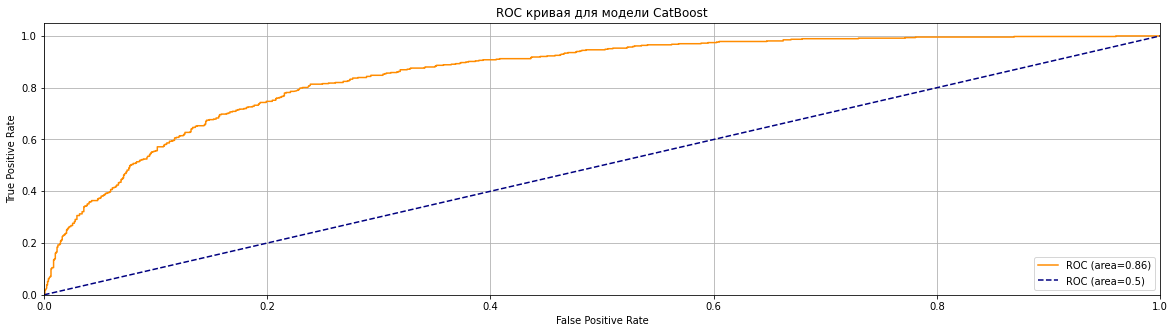

In [76]:
fpr, tpr, treshold = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC (area={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='ROC (area=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для модели CatBoost')
plt.grid()
plt.legend(loc="lower right");

И посмотрим метрику:

In [77]:
print(f'ROC-AUC {roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])}')

ROC-AUC 0.8573695009263606


0.857 на тестовой - неплохо, немного выше, чем оценка кроссвалидации. Результат выше необходимого минимума.

*Основные метрики классификации*

In [78]:
print(classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1291
           1       0.68      0.52      0.59       467

    accuracy                           0.81      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.80      0.81      0.80      1758



Можно обратить внимание, что модель достаточно неплохо предсказывает, что клиент не уйдет. Для клиентов, которые собираются уходить, точность не особо высокая.

**Важность признаков**

In [79]:
feature_importance = final_model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,type,27.486966
1,date_delta,23.241440
2,monthly_charges,11.491574
3,internet_service,6.740288
4,tech_support,5.137694
5,delta_charges,4.257429
6,multiple_lines,4.095657
7,streaming_tv,3.728045
8,online_security,3.247995
9,payment_method,2.880993


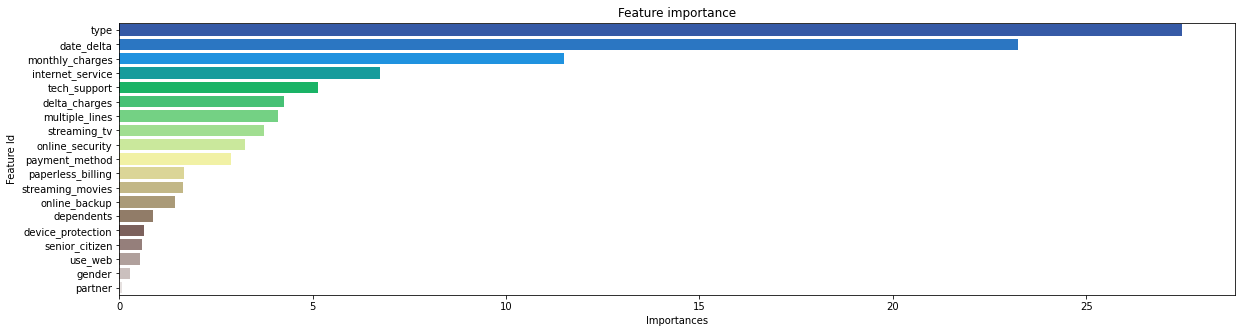

In [80]:
sns.barplot(data=feature_importance, x='Importances', y='Feature Id',  palette='terrain')
plt.title('Feature importance');

Наиболее важные признаки:
- type
- date_delta
- mountly_charges

Есть достаточно много признаков с небольшим уровнем значимости. Иногда их удаление улучшает качество модели. 

## Общий вывод

Цель исследования -  создание модели, предсказывающей вероятность ухода клиента из компании. Целевая метрика - ROC-AUC.

При выполнении работы были выполнены следущие пункты:  

### Загрузка данных  
Было проверно, что файлы с данными
- contract.csv  — информация о договоре
- personal.csv — персональные данные клиента
- internet.csv — информация об интернет-услугах
- phone.csv — информация об услугах телефонии   

содержат уникальные `customerID`, после чего по этому ID объединены в один датафрейм.

По параметру `end_date` был создан целевой признак - ушел клиент или нет. В случае, если поле не заполнено датой - клиент на текущий момент остается в компании.

Всего 7043 клиентов, из них 5517 пользователей интернета и 6361 телефонии. Для пользователей изветно 19 признаков(не считая целевой).

### Предобработка данных и исследовательский анализ

В процессе первоначальной оценки данных была выявлена аномалия в столбце `total_charges` (всего потрачено денег на услуги) - для пользователей, только что присоединившихся к компании значения были `' '`. Подобных записей мало, было принято решение удалить эти строки - данные пользователи бесполезны для обучения модели, т.к. только пришли в компанию, для оценки "ушел-остался" необходим, как минимум, месяц.  
Средствами `pandas_profiling` проведены анализ всех параметров, корреляции, дубликатов и пропусков.  
- были обнаружены пропуски, которые образовались при слиянии данных. это пропуски в параметрах, связанных с интернет услугами и телефонной связью
- было обнаружено несколько дубликатов, но т.к. все ID уникальные их можно оставить

Все пропуски в категориальных переменных, их заполним новой категорией "Не использует" ("Not Use", -1).  
Принято решение сформировать несколько новых признаков:  
- сколько месяцев человек в компании 
- какая разница между тем, сколько человек платит сейчас и сколько он платил в среднем за все время пользования услугами
- каким количеством дополнительных услуг он пользуется.

Был обнаружен дисбаланс в целевом признаке   
![](target.jpg)  
остается клиентов больше, чем уходит.  
Было обнаружено, что некоторые параметры практически не влияют на целевой признак (например, gender - люди любого пола уходят примерно одинаково).  
Некоторые параметры сильно влияют на целевой. 
- уходят много людей, которые пользуются `Fiber Optic` (параметр `internet_service`)
- уходят много людей, у которых нет выделенной линии техподдержки(`tech_support`) и блокировки небезопасных сайтов(`online_security`) 
- типа оплаты `type` - большинство ушедших платили только за месяц
- очень много ушедших оплачивало услуги `payment_method` - "Electronic Check"
- `total_charges` и `date_delta` - чем больше времени человек в компании, тем больше шанс, что он останется

Ежемесячная оплата `monthly_charges` имеет мультимодальное распределение, визуально можно выделить три группы. Большинство ушедших платило достаточно много.

### Моделирование

Была отделена тестовая выборка.

Для предварительной оценки использовался CatBoostClassifier с построением графика процесса обучения - было определено приблизительное необходимое количество итераций, проверены несколько наборов данных с разными признаками. В итоге было принято решение удалить признаки `total_charges` и созданный `service_sum`.

Выбраны модели:

- LogisticRegression (предобработка OHE + StandartScaler)
- RandomForestClassifier (Ordinal)
- CatBoostClassifier (данные без обработки)
- KNeighborsClassifier (предобработка OHE + StandartScaler)
- StackingClassifier и VotingClassifier (топ-3 лучших моделей из полученных выше)

Для регрессии и леса проверен вариант с устранением дисбаланса целевого с помощью SMOTE.

Полученные результаты:

|    | Модель      |   roc_auc |
|---:|:----------|----------:|
|  0 | LogReg    |  0.840695 |
|  1 | LogRegSM  |  0.8398   |
|  2 | RForest   |  0.843199 |
|  3 | RForestSM |  0.839672 |
|  4 | KNN       |  0.830635 |
|  5 | Cat       |  0.847495 |
|  6 | Vot       |  0.847173 |
|  7 | Stack     |  0.847361 |


Лучший результат показала модель на основе CatBoostClassifier с гиперпараметрами: eta = 0.03, iterations=400, l2_leaf_reg=20, min_data_in_leaf=50, subsample=0.6.

### Тестирование модели

Полученная модель была проверена на тестовой выборке и показала результат ROC-AUC = 0.857.  
Проведена проверка на адекватность модели - сравнение с DummyClassifier (результат ~0.5). Выбранная модель адекватна.  

Исследована значимость признаков, топ-5:  

|    | Feature Id       |   Importances |
|---:|:-----------------|--------------:|
| Тип оплаты  | type             |      27.487   |
|  Сколько человек в компании | date_delta       |      23.2414  |
|  Ежемесячный платеж | monthly_charges  |      11.4916  |
|  Интернет | internet_service |       6.74029 |
|  Выделенная линия поддержки | tech_support     |       5.13769 |



### Ввод модели в продакшн

На основе Flask была разработана и запущена модель http://evil-bird.ru/ 

![](flask.png)

### Результат
В процессе исследования были изучены данные и разработана модель, которая предсказывает вероятность ухода клиента.  Был достигнут результат по целевой метрике 0.85. Можно рекомендовать модель для внедрения.